# ResNet 50

A TensorFlow reconstruction of ResNet50. Some useful links:

* [KERAS implementation](https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py)
* [NetScope visualisation of the network](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006)
* [KERAS pre-trained weights (h5)](https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5)

In [1]:
import os

import numpy as np

import h5py

import tensorflow as tf
print tf.__version__

1.2.1


---
### Data

In [2]:
PARAMS_PATH = ''
PARAMS_FILE = PARAMS_PATH + 'resnet50_weights_tf_dim_ordering_tf_kernels.h5'

# LOG_PATH = ''
# LOG_DIRECTORY = LOG_PATH + 'Tensorflow/model-resnet50/logs'
# if not os.path.exists(LOG_DIRECTORY):
#     os.makedirs(LOG_DIRECTORY)

In [3]:
data_h5 = h5py.File(PARAMS_FILE, 'r')

variables = [ key for key in data_h5.keys() if len(data_h5[key])>0 ]
print variables

[u'bn2a_branch1', u'bn2a_branch2a', u'bn2a_branch2b', u'bn2a_branch2c', u'bn2b_branch2a', u'bn2b_branch2b', u'bn2b_branch2c', u'bn2c_branch2a', u'bn2c_branch2b', u'bn2c_branch2c', u'bn3a_branch1', u'bn3a_branch2a', u'bn3a_branch2b', u'bn3a_branch2c', u'bn3b_branch2a', u'bn3b_branch2b', u'bn3b_branch2c', u'bn3c_branch2a', u'bn3c_branch2b', u'bn3c_branch2c', u'bn3d_branch2a', u'bn3d_branch2b', u'bn3d_branch2c', u'bn4a_branch1', u'bn4a_branch2a', u'bn4a_branch2b', u'bn4a_branch2c', u'bn4b_branch2a', u'bn4b_branch2b', u'bn4b_branch2c', u'bn4c_branch2a', u'bn4c_branch2b', u'bn4c_branch2c', u'bn4d_branch2a', u'bn4d_branch2b', u'bn4d_branch2c', u'bn4e_branch2a', u'bn4e_branch2b', u'bn4e_branch2c', u'bn4f_branch2a', u'bn4f_branch2b', u'bn4f_branch2c', u'bn5a_branch1', u'bn5a_branch2a', u'bn5a_branch2b', u'bn5a_branch2c', u'bn5b_branch2a', u'bn5b_branch2b', u'bn5b_branch2c', u'bn5c_branch2a', u'bn5c_branch2b', u'bn5c_branch2c', u'bn_conv1', u'conv1', u'fc1000', u'res2a_branch1', u'res2a_branch2

In [4]:
print list(data_h5['bn2a_branch1'])

[u'bn2a_branch1_beta:0', u'bn2a_branch1_gamma:0', u'bn2a_branch1_running_mean:0', u'bn2a_branch1_running_std:0']


In [5]:
print data_h5['bn2a_branch1']['bn2a_branch1_beta:0'].shape
print data_h5['bn2a_branch1']['bn2a_branch1_gamma:0'].value[:5]

(256,)
[ 0.30266267  1.10643625  1.773862    0.81150401  1.0933665 ]


#### Model Components

In [6]:
# ----------------------- #
def dense_layer(input_layer, data, layer_name):
    with tf.variable_scope(layer_name):
        W = tf.constant( data[layer_name][layer_name+'_W:0'] )
        b = data[layer_name][layer_name+'_b:0']
        b = tf.constant( np.reshape(b, (b.shape[0])) )
        x = tf.matmul(input_layer, W)
        x = tf.nn.bias_add(x, b)
        return x
    # ----------------------- #


# ----------------------- #
def conv_layer(input_layer, data, layer_name, strides=[1,1,1,1], padding='VALID'):
    with tf.variable_scope(layer_name):
        W = tf.constant( data[layer_name][layer_name+'_W:0'] )
        b = data[layer_name][layer_name+'_b:0']
        b = tf.constant( np.reshape(b, (b.shape[0])) )
        x = tf.nn.conv2d(input_layer, filter=W, strides=strides, padding=padding, name=layer_name)
        x = tf.nn.bias_add(x, b)
        return x
    # ----------------------- #


# ----------------------- #
def batch_norm_layer(input_layer, data, layer_name):
    with tf.variable_scope(layer_name):
        mean = tf.constant( data[layer_name][layer_name+'_running_mean:0'] )
        std = tf.constant( data[layer_name][layer_name+'_running_std:0'] )
        beta = tf.constant( data[layer_name][layer_name+'_beta:0'] )
        gamma = tf.constant( data[layer_name][layer_name+'_gamma:0'] )
        return tf.nn.batch_normalization(
            input_layer, mean=mean, variance=std, 
            offset=beta, scale=gamma, 
            variance_epsilon=1e-12, name='batch-norm')
    # ----------------------- #


# ----------------------- #
def conv_block(input_layer, stage, data, strides=[1, 2, 2, 1]):
    
    with tf.variable_scope('conv_block'):
        
        x = conv_layer(input_layer, data=data, layer_name='res'+stage+'_branch2a', strides=strides)
        x = batch_norm_layer(x, data=data, layer_name='bn'+stage+'_branch2a')
        x = tf.nn.relu(x)
        
        x = conv_layer(x, data=data, layer_name='res'+stage+'_branch2b', padding='SAME')
        x = batch_norm_layer(x, data=data, layer_name='bn'+stage+'_branch2b')
        x = tf.nn.relu(x)
        
        x = conv_layer(x, data=data, layer_name='res'+stage+'_branch2c')
        x = batch_norm_layer(x, data=data, layer_name='bn'+stage+'_branch2c')
        
        shortcut = conv_layer(input_layer, data=data, layer_name='res'+stage+'_branch1', strides=strides)
        shortcut = batch_norm_layer(shortcut, data=data, layer_name='bn'+stage+'_branch1')
        
        x = tf.add(x, shortcut)
        x = tf.nn.relu(x)
        
    return x
    # ----------------------- #


# ----------------------- #
def identity_block(input_layer, stage, data):
    
    with tf.variable_scope('identity_block'):
        
        x = conv_layer(input_layer, data=data, layer_name='res'+stage+'_branch2a')
        x = batch_norm_layer(x, data=data, layer_name='bn'+stage+'_branch2a')
        x = tf.nn.relu(x)
        
        x = conv_layer(x, data=data, layer_name='res'+stage+'_branch2b', padding='SAME')
        x = batch_norm_layer(x, data=data, layer_name='bn'+stage+'_branch2b')
        x = tf.nn.relu(x)
        
        x = conv_layer(x, data=data, layer_name='res'+stage+'_branch2c')
        x = batch_norm_layer(x, data=data, layer_name='bn'+stage+'_branch2c')
        
        x = tf.add(x, input_layer)
        x = tf.nn.relu(x)
        
    return x
    # ----------------------- #

In [7]:
tf.reset_default_graph()

RESNET_HEIGHT = 224
RESNET_WIDTH = 224

image_input = tf.placeholder(dtype=tf.float32, shape=[None, RESNET_HEIGHT, RESNET_WIDTH, 3], name='input')
image = tf.pad(image_input, [[0,0],[3,3],[3,3],[0,0]], "CONSTANT", name='zeropadding-3')


with tf.variable_scope('stage1'):
    res = conv_layer(image, data_h5, 'conv1', strides=[1, 2, 2, 1])
    res = batch_norm_layer(res, data_h5, 'bn_conv1')
    res = tf.nn.relu(res)
    res = tf.nn.max_pool(res, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID', name='pool_conv1')
    print 'Stage 1', res.get_shape()


with tf.variable_scope('stage2'):
    res = conv_block(input_layer=res, stage='2a', data=data_h5, strides=[1, 1, 1, 1])
    res = identity_block(input_layer=res, stage='2b', data=data_h5)
    res = identity_block(input_layer=res, stage='2c', data=data_h5)
    print 'Stage 2', res.get_shape()


with tf.variable_scope('stage3'):
    res = conv_block(input_layer=res, stage='3a', data=data_h5)
    res = identity_block(input_layer=res, stage='3b', data=data_h5)
    res = identity_block(input_layer=res, stage='3c', data=data_h5)
    res = identity_block(input_layer=res, stage='3d', data=data_h5)
    print 'Stage 3', res.get_shape()


with tf.variable_scope('stage4'):
    res = conv_block(input_layer=res, stage='4a', data=data_h5)
    res = identity_block(input_layer=res, stage='4b', data=data_h5)
    res = identity_block(input_layer=res, stage='4c', data=data_h5)
    res = identity_block(input_layer=res, stage='4d', data=data_h5)
    res = identity_block(input_layer=res, stage='4e', data=data_h5)
    res = identity_block(input_layer=res, stage='4f', data=data_h5)
    print 'Stage 4', res.get_shape()


with tf.variable_scope('stage5'):
    res = conv_block(input_layer=res, stage='5a', data=data_h5)
    res = identity_block(input_layer=res, stage='5b', data=data_h5)
    res = identity_block(input_layer=res, stage='5c', data=data_h5)
    print 'Stage 5', res.get_shape()


with tf.variable_scope('stage-final'):
    res = tf.nn.avg_pool(res, ksize=[1, 7, 7, 1], strides=[1, 1, 1, 1], padding='VALID', name='pool_conv1')
    print 'Pool 5', res.get_shape()
    
    # Add the dense layer.
    res = tf.reshape(res, (-1, res.get_shape()[3].value))
    res = dense_layer(input_layer=res, layer_name='fc1000', data=data_h5)
    res = tf.nn.softmax(res)
    print 'Output probabilities', res.get_shape()

Stage 1 (?, 55, 55, 64)
Stage 2 (?, 55, 55, 256)
Stage 3 (?, 28, 28, 512)
Stage 4 (?, 14, 14, 1024)
Stage 5 (?, 7, 7, 2048)
Pool 5 (?, 1, 1, 2048)
Output probabilities (?, 1000)


---
### Testing

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

import scipy.misc

import pandas as pd

In [20]:
def load_image(path):
    
    image = scipy.misc.imread(path)
    
    # Crop to square.
    min_dim = np.min(image.shape[:2])
    height_dim0 = (image.shape[0]-min_dim) // 2
    height_dim1 = image.shape[0] + ((image.shape[0]-min_dim) // 2)
    width_dim0 = (image.shape[1]-min_dim) // 2
    width_dim1 = min_dim + ((image.shape[1]-min_dim) // 2)
    image_cropped = image[height_dim0:height_dim1, width_dim0:width_dim1, :]
    
    # Resize to ResNet input dimensions.
    image_resized = scipy.misc.imresize(image_cropped, [RESNET_HEIGHT, RESNET_WIDTH])
    
    return image_resized

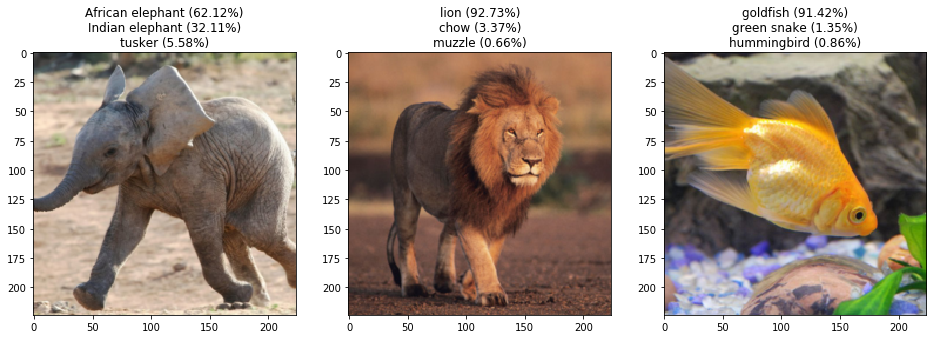

In [66]:
sess = tf.InteractiveSession()

# Get the imagenet labels
with open('../labels/imagenet-labels-1001.txt') as file: # First row is a dummy.
    labels = file.readlines()
labels = [ x.strip() for x in labels ] 
df = pd.DataFrame({ 'labels':labels[1:], 'probabilities': np.zeros((1000,)) })

# Set the path to the images to load.
images = ['../images/elephant.jpg', '../images/lion.jpg', '../images/goldfish.jpg']


plt.figure(figsize=(16,6))

for i, image_path in enumerate(images):
    
    image = load_image(image_path)
    
    probs = sess.run( 
        tf.get_default_graph().get_tensor_by_name("stage-final/Softmax:0"), 
        feed_dict={ image_input: image.reshape((1, RESNET_HEIGHT, RESNET_WIDTH, 3)) } )
    plt.subplot(1, len(images), i+1)
    plt.imshow(image)
    ixs = probs[0].argsort()[-3:][::-1]
    title = ''
    for j,ix in enumerate(ixs):
        if j > 0:
            title += '\n'
        title += df['labels'].loc[ix] + ' ({:3.2f}%)'.format(probs[0,ix]*100)
    plt.title(title)